In [ ]:
# Block-1
!pip install google-cloud-storage google-cloud-aiplatform pandas matplotlib --quiet

from google.colab import auth
auth.authenticate_user()
print("✅ Colab authenticated")


✅ Colab authenticated


In [ ]:
# Block-2
import heapq
import json
import math
import time
from datetime import datetime
import os

import pandas as pd
import matplotlib.pyplot as plt

# Vertex AI imports(if API changes, the try/except below handles it)
import vertexai
from vertexai.preview import generative_models

from google.cloud import storage

# --- REPLACE THESE with your real project/bucket ---
PROJECT_ID = "retail-agent-474417"
BUCKET_NAME = "retail-agent-2-bucket"

# Initialize Vertex AI (region can be changed if needed)
LOCATION = "us-central1"
vertexai.init(project=PROJECT_ID, location=LOCATION)
print(f"✅ Vertex AI initialized for project={PROJECT_ID}, location={LOCATION}")

# Try to create model client object; if fail, set gemini=None and continue
gemini = None
try:
    gemini = generative_models.GenerativeModel("projects/retail-agent-474417/locations/us-central1/publishers/google/models/gemini-2.5-flash")
    print("✅ Gemini model object initialized")
except Exception as e:
    print("⚠️ Could not initialize Gemini model object:", e)
    print("The code will continue but AI reasoning calls will return a safe message.")

# Storage client
storage_client = storage.Client(project=PROJECT_ID)
bucket = storage_client.bucket(BUCKET_NAME)

# --- Robot Setup ---
robot_status = {
    "R1": {"position": [0, 0], "status": "free", "eta": 0},
    "R2": {"position": [5, 5], "status": "free", "eta": 0}
}
task_queue = []
assignments = []
completed_items = set()
current_time = 0

print("✅ Environment & robot setup complete")


✅ Vertex AI initialized for project=retail-agent-474417, location=us-central1
✅ Gemini model object initialized
✅ Environment & robot setup complete


/usr/local/lib/python3.11/dist-packages/vertexai/generative_models/_generative_models.py:433: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


In [ ]:
# Block-3
# ------------------------------------------------------------------
# This version reads the restock request JSON uploaded by Agent 1
# into the shared bucket "agents-shared-data".
# ------------------------------------------------------------------

# Shared bucket details
SHARED_BUCKET_NAME = "retail_data_agent"
REQUESTS_BLOB_PATH = "restock_requests/restock_requests_20251010_075816.json"  # The exact file Agent 1 uploaded

def load_incoming_requests():
    """Load restock requests produced by Agent 1 from the shared bucket."""
    try:
        # Connect to shared bucket
        shared_client = storage.Client()
        shared_bucket = shared_client.bucket(SHARED_BUCKET_NAME)
        blob = shared_bucket.blob(REQUESTS_BLOB_PATH)

        if not blob.exists():
            print(f"❌ File not found: gs://{SHARED_BUCKET_NAME}/{REQUESTS_BLOB_PATH}")
            return []

        text = blob.download_as_text()
        data = json.loads(text)

        # Allow single or multiple requests
        if isinstance(data, dict):
            data = [data]

        print(f"✅ Loaded {len(data)} request(s) from gs://{SHARED_BUCKET_NAME}/{REQUESTS_BLOB_PATH}")
        return data

    except Exception as e:
        print(f"⚠ Failed to load incoming requests: {e}")
        return []

# Load requests from shared bucket
incoming_requests = load_incoming_requests()

✅ Loaded 10 request(s) from gs://retail_data_agent/restock_requests/restock_requests_20251010_075816.json


In [ ]:
# Block-4
def calculate_distance(r_pos, item_pos):
    # simple Euclidean distance
    return math.dist(r_pos, item_pos)

def add_request_to_queue(request):
    urgency = float(request.get("urgency", 1))
    location = request.get("location", [0, 0])
    d1 = calculate_distance(robot_status["R1"]["position"], location)
    d2 = calculate_distance(robot_status["R2"]["position"], location)
    best_dist = min(d1, d2)
    # Higher urgency -> higher priority; lower distance -> higher priority
    # We invert sign because heapq is a min-heap; using negative to get max-like behavior
    priority = -(urgency * 100 - best_dist)
    heapq.heappush(task_queue, (priority, request))

def get_next_free_robot():
    # returns robot with smallest ETA (soonest free)
    return min(robot_status.keys(), key=lambda r: robot_status[r]["eta"])


In [ ]:
# Block-5
def get_ai_reasoning(request, chosen_robot):
    """Ask Gemini why this robot is the better choice.
       If the Gemini object isn't available or call fails, return a safe string with the error.
    """
    prompt = f"""
Two shelf-restock robots:
• R1 at {robot_status['R1']['position']} (status {robot_status['R1']['status']})
• R2 at {robot_status['R2']['position']} (status {robot_status['R2']['status']}).

Next restock request:
  Item ID: {request.get('item_id')}
  Location: {request.get('location')}
  Urgency: {request.get('urgency')}
  Quantity: {request.get('quantity')}

The coordinator selected {chosen_robot}.
Explain briefly (1-2 sentences) why this is a good assignment.
"""

    if gemini is None:
        return "(AI reasoning unavailable: model client not initialized)"
    try:
        # Some SDKs return an object with .text, some use `.response` or `.generate()`.
        # We attempt a common pattern and fall back safely.
        response = gemini.generate_content(prompt)
        # Some wrappers return a list or object; handle common shapes
        if hasattr(response, "text"):
            return response.text.strip()
        # Try dictionary-like
        if isinstance(response, dict) and "text" in response:
            return str(response["text"]).strip()
        # fallback:
        return str(response).strip()
    except Exception as e:
        return f"(AI reasoning unavailable: {e})"


In [ ]:
# Block-6
def assign_task_llm(current_time):
    if not task_queue:
        return None, current_time

    _, request = heapq.heappop(task_queue)
    item_id = request.get("item_id")
    if item_id in completed_items:
        # skip duplicated requests
        return None, current_time

    location = request.get("location", [0, 0])
    qty = request.get("quantity", 1)
    free_robots = [r for r, d in robot_status.items() if d["status"] == "free"]

    # choose closest free robot or soonest-free robot
    if free_robots:
        best_robot, best_dist = None, float("inf")
        for r in free_robots:
            dist = calculate_distance(robot_status[r]["position"], location)
            if dist < best_dist:
                best_robot, best_dist = r, dist
    else:
        best_robot = get_next_free_robot()
        # advance current time to when it becomes free
        current_time = robot_status[best_robot]["eta"]
        robot_status[best_robot]["status"] = "free"

    if best_robot is None:
        # Defensive fallback
        print("❌ No robot available to assign")
        return None, current_time

    # Travel time approximated as integer distance
    travel_time = int(calculate_distance(robot_status[best_robot]["position"], location))
    completion_time = int(current_time + travel_time + 2)  # +2 for handling time
    robot_status[best_robot].update({
        "status": "busy",
        "position": location,
        "eta": completion_time
    })

    reasoning = get_ai_reasoning(request, best_robot)

    assignment = {
        "task_id": f"TASK_{item_id}_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
        "robot_id": best_robot,
        "pickup_location": [0, 0],
        "delivery_location": location,
        "item_id": item_id,
        "quantity": qty,
        "assigned_at": current_time,
        "expected_finish": completion_time,
        "ai_reasoning": reasoning
    }
    assignments.append(assignment)
    completed_items.add(item_id)

    print(f"\n⚡ Assigned {item_id} → {best_robot}")
    print("🤖 Reasoning:", reasoning)
    return assignment, current_time


In [ ]:
# Block-7
# Fill queue
for req in incoming_requests:
    try:
        add_request_to_queue(req)
    except Exception as e:
        print("⚠️ Skipped request due to error:", e)

# Process tasks
while task_queue:
    _, current_time = assign_task_llm(current_time)

print("\n🏁 All tasks scheduled!")

# Save + upload to Cloud Storage
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = f"robot_assignments_{timestamp}.json"
with open(output_file, "w") as f:
    json.dump(assignments, f, indent=2)

try:
    out_blob = bucket.blob(f"robot_assignments/{output_file}")
    out_blob.upload_from_filename(output_file)
    print(f"☁ Uploaded results → gs://{BUCKET_NAME}/robot_assignments/{output_file}")
except Exception as e:
    print("⚠️ Failed to upload results to Cloud Storage:", e)
    print("📁 Results saved locally as", output_file)


⚠️ Skipped request due to error: '<' not supported between instances of 'dict' and 'dict'

⚡ Assigned Eggs003 → R2
🤖 Reasoning: R2 is already at the requested location [8, 4], eliminating any travel time for this specific task. This makes it the most efficient choice, as it can fulfill the request immediately upon completing its current activity at that same spot.

⚡ Assigned Fish014 → R1
🤖 Reasoning: R1 is already at the restock location of [8, 4], eliminating any travel time for the task. Although currently busy, its immediate proximity makes it the most efficient choice once it becomes available.

⚡ Assigned Salt021 → R2
🤖 Reasoning: R2 is already at the restock location [3, 9], minimizing travel time and making it the most efficient robot for this task once it becomes available.

⚡ Assigned Cheese023 → R1
🤖 Reasoning: R1 is currently at the exact location [2, 6] where the restock is needed, minimizing travel time and making it the most efficient robot for this task.

⚡ Assigned Mil


📈 Task Distribution:
robot_id
R2    5
R1    5
Name: count, dtype: int64


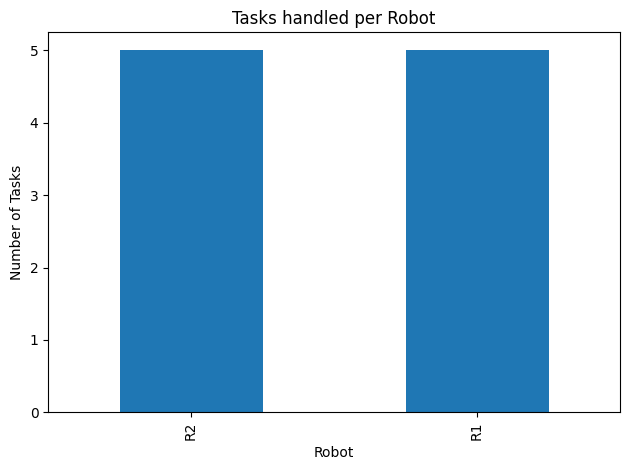

In [ ]:
# Block-8a
# Simple summary
if not assignments:
    print("ℹ️ No assignments to summarize.")
else:
    df = pd.DataFrame(assignments)
    print("\n📈 Task Distribution:")
    print(df["robot_id"].value_counts())

    # Bar chart (matplotlib; colors left default to avoid forced styling)
    ax = df["robot_id"].value_counts().plot(kind="bar", title="Tasks handled per Robot")
    ax.set_xlabel("Robot")
    ax.set_ylabel("Number of Tasks")
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128722 (\N{SHOPPING TROLLEY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


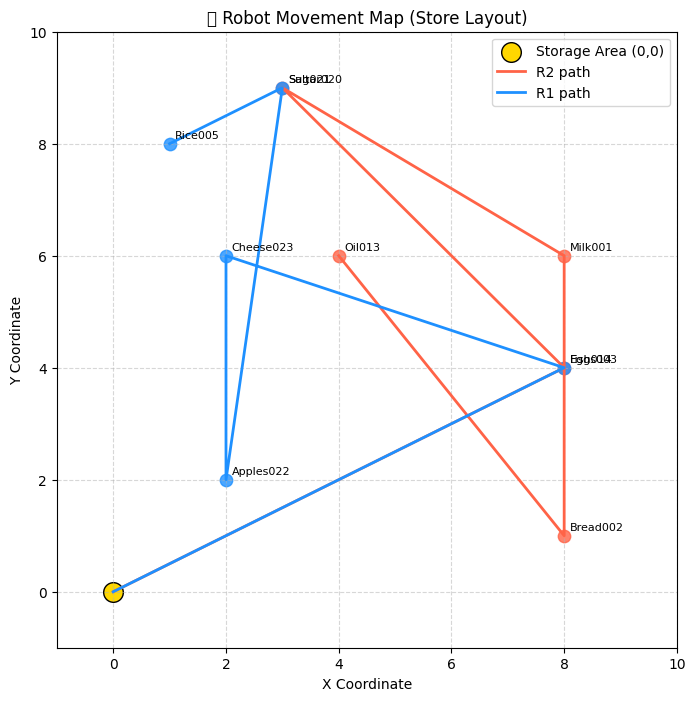

In [ ]:
#Block-8b
import matplotlib.pyplot as plt
import numpy as np

# Convert assignments into a DataFrame
df = pd.DataFrame(assignments)

# --- Visualization Setup ---
plt.figure(figsize=(8, 8))
plt.title("🛒 Robot Movement Map (Store Layout)")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True, linestyle="--", alpha=0.5)

# Define colors for each robot
colors = {"R1": "dodgerblue", "R2": "tomato"}

# Starting position (storage area)
storage_pos = np.array([0, 0])
plt.scatter(*storage_pos, color="gold", s=200, label="Storage Area (0,0)", edgecolor="black")

# Plot each robot's movement path
for robot_id in df["robot_id"].unique():
    robot_df = df[df["robot_id"] == robot_id]
    path_x, path_y = [0], [0]  # start from storage

    for _, row in robot_df.iterrows():
        loc = row["delivery_location"]
        path_x.append(loc[0])
        path_y.append(loc[1])
        plt.scatter(loc[0], loc[1], color=colors[robot_id], s=80, alpha=0.8)
        plt.text(loc[0]+0.1, loc[1]+0.1, row["item_id"], fontsize=8)

    plt.plot(path_x, path_y, color=colors[robot_id], linewidth=2, label=f"{robot_id} path")

# Annotate legend and layout
plt.legend()
plt.xlim(-1, 10)
plt.ylim(-1, 10)
plt.show()